# 🔥 Diffusion Models

In this notebook, we'll walk through the steps required to train your own diffusion model on the Oxford flowers dataset

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from ddm.utils import display_imgs

## 0. Parameters <a name="parameters"></a>

In [23]:
IMAGE_SIZE = 64
BATCH_SIZE = 64
# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
DATASET_REPETITIONS = 5
EPOCHS = 5 # or 50 if you want to see better results

CHECKPOINT_PATH = './checkpoint/checkpoint_notebook.ckpt'

## 1. Prepare the Data

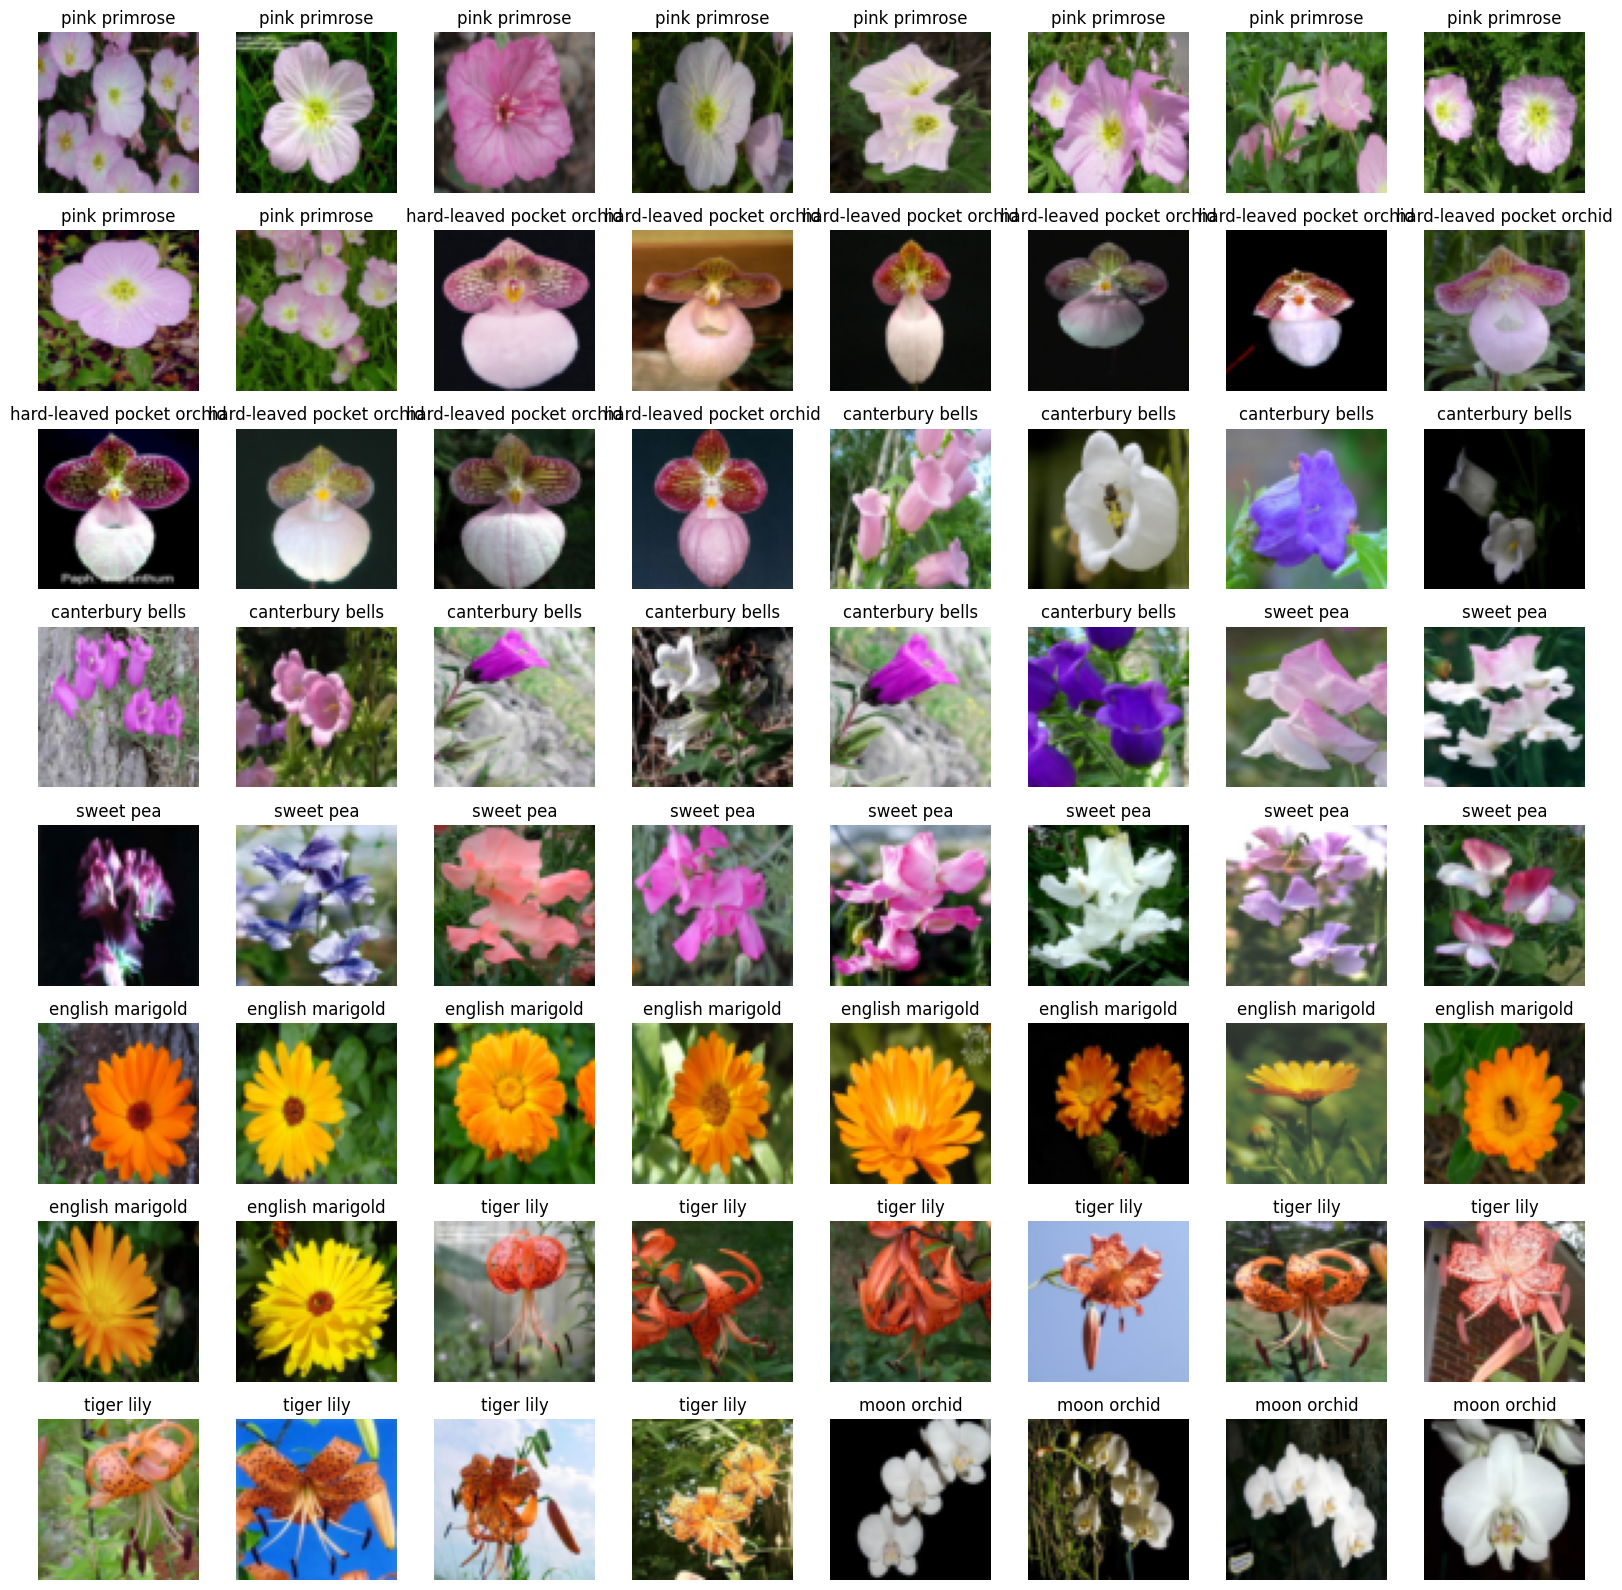

In [3]:
import pandas as pd

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# load dataset (already normalized to [0,1])
train_dataset = Flowers102(
    root="../../data/flower-dataset",
    split="train",
    transform=transform,
    download=True
)

# fetch additional labels for fun
flower_names = pd.read_csv(r"../../data/oxford_flower_102_name.csv")
setattr(train_dataset, 'idx_to_str',  list(flower_names["Name"]))

# preview
# Show first 64 images from the training set in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
for idx, ax in enumerate(axes.flat):
    img = train_dataset[idx][0].permute(1, 2, 0)  # convert from CxHxW to HxWxC
    label = train_dataset[idx][1]
    ax.imshow(img)
    ax.set_title(train_dataset.idx_to_str[label])
    ax.axis("off")
plt.tight_layout()
plt.show()


In [4]:
# Repeat the dataset by concatenating it DATASET_REPETITIONS times
train_dataset_repeated = torch.utils.data.ConcatDataset([train_dataset] * DATASET_REPETITIONS)

train_data = DataLoader(
    train_dataset_repeated, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

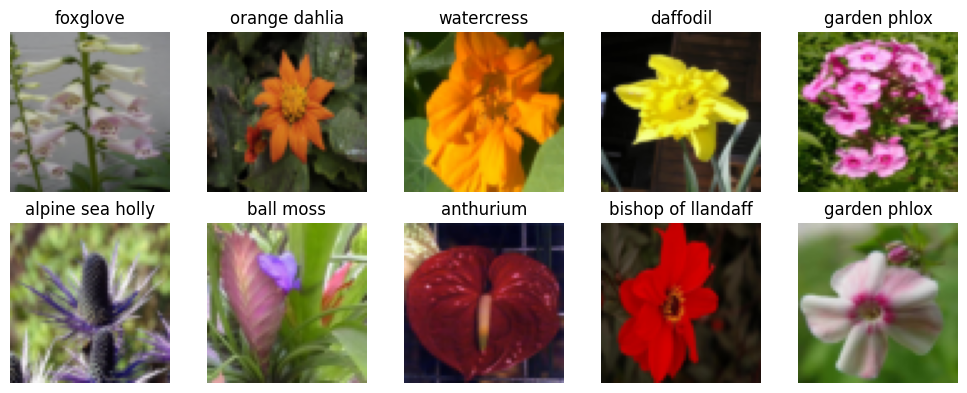

In [5]:
train_sample = next(iter(train_data))
# Show first 16 images from the training set in a 4x4 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for idx, ax in enumerate(axes.flat):
    img = train_sample[0][idx].permute(1, 2, 0)  # convert from CxHxW to HxWxC
    label = train_sample[1][idx].item()
    ax.imshow(img)
    ax.set_title(train_dataset.idx_to_str[label])
    ax.axis("off")
plt.tight_layout()
plt.show()

### 1.1 Diffusion schedules <a name="diffusion_schedules"></a>

In [6]:
from ddm.net import linear_diffusion_schedule, cosine_diffusion_schedule, offset_cosine_diffusion_schedule

T = 1000
diffusion_times = torch.linspace(0, 1, T)
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(diffusion_times)
cosine_noise_rates, cosine_signal_rates = cosine_diffusion_schedule(diffusion_times)
offset_cosine_noise_rates, offset_cosine_signal_rates = offset_cosine_diffusion_schedule(diffusion_times)

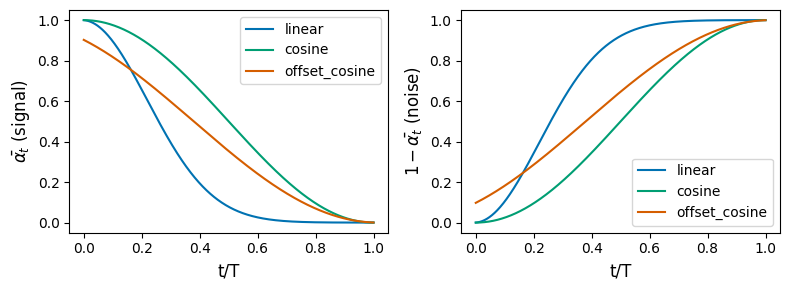

In [7]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(
    diffusion_times, linear_signal_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_signal_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_signal_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)
plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(
    diffusion_times, linear_noise_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_noise_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_noise_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)
plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$1-\bar{\alpha_t}$ (noise)", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


## 2. Build the model <a name="build"></a>

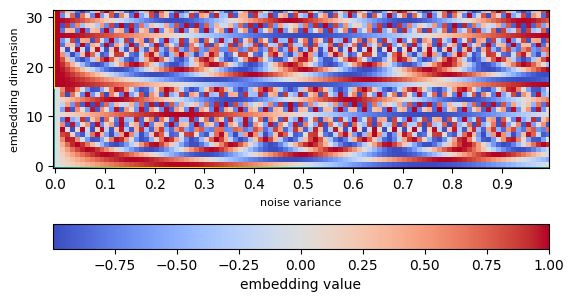

In [8]:
from ddm.net import sinusoidal_embedding
embedding_array = sinusoidal_embedding(torch.linspace(0.0,1.0,100).reshape((100,1))).T
fig, ax = plt.subplots()
ax.set_xticks(
    torch.arange(0, 100, 10), labels=np.round(np.arange(0.0, 1.0, 0.1), 1)
)
ax.set_ylabel("embedding dimension", fontsize=8)
ax.set_xlabel("noise variance", fontsize=8)
plt.pcolor(embedding_array, cmap="coolwarm")
plt.colorbar(orientation="horizontal", label="embedding value")
ax.imshow(embedding_array, interpolation="nearest", origin="lower")
plt.show()

In [9]:
from ddm.net import UNet, DiffusionModel
ddm = DiffusionModel(UNet, offset_cosine_diffusion_schedule, EMA=0.999)

## 3.Train the model <a name="train"></a>

In [24]:
from ddm.utils import ImageGenerator
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

def train_model():
    optimizer = torch.optim.AdamW(ddm.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = torch.nn.L1Loss()

    writer = SummaryWriter()
    image_generator_callback = ImageGenerator(ddm, num_img=10)
    
    for epoch in range(EPOCHS):
        epoch_bar = tqdm(train_data, desc=f"Epoch {epoch + 1}/{EPOCHS}")
        for images, _ in epoch_bar:
            images = images.to(next(ddm.parameters()).device)   
            # 执行一次训练 step
            loss = ddm.train_step(images, optimizer, criterion) 
            # 更新 tqdm 上显示的信息
            epoch_bar.set_postfix(loss=loss)    
            # 写入 TensorBoard 每 batch 的 loss
            writer.add_scalar('Loss/train_step', loss, global_step)
            global_step += 1    
        # 每个 epoch 结束后生成图像
        image_generator_callback.on_epoch_end(epoch)    
        # 保存模型
        torch.save(ddm.state_dict(), )    
        # 写入 TensorBoard 每个 epoch 的 loss
        writer.add_scalar('Loss/train_epoch_avg', loss, epoch)

## 4. Inference <a name="inference"></a>

C:\Users\ming\AppData\Local\Temp\ipykernel_25024\2546462216.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ddm.load_state_dict(torch.load(CHECKPOINT_PATH))


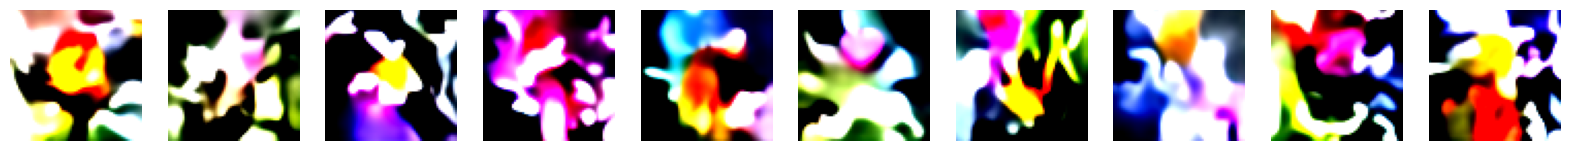

In [29]:
LOAD_MODEL = True

device = 'cuda' if torch.cuda.is_available else 'cpu'

if LOAD_MODEL:
    ddm.load_state_dict(torch.load(CHECKPOINT_PATH))
    ddm.to(device)
    
# Generate some novel images of flowers
with torch.no_grad():
    ddm.train() # FIXME eval mode does not work properly
    generated_images = ddm.generate(num_images=10, diffusion_steps=20).permute(0,2,3,1).cpu().numpy()
display_imgs(generated_images)

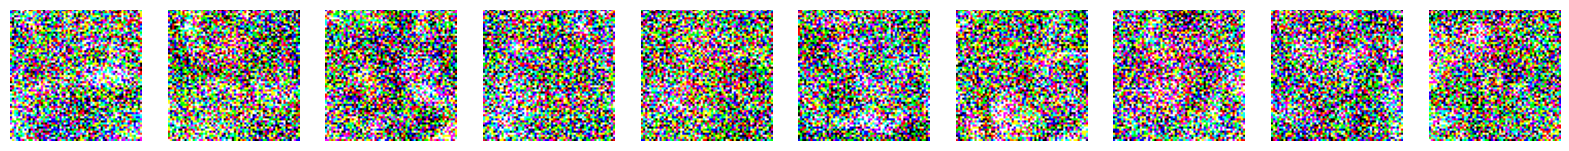

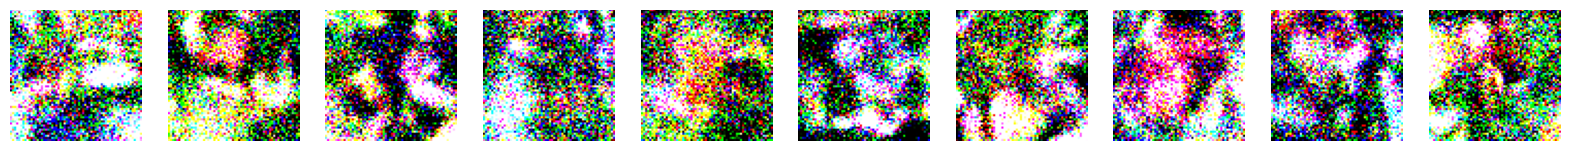

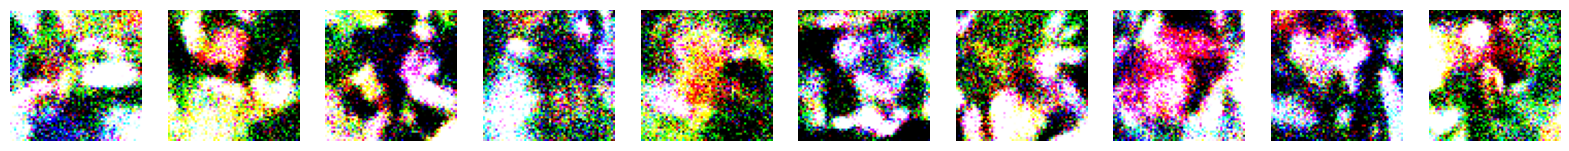

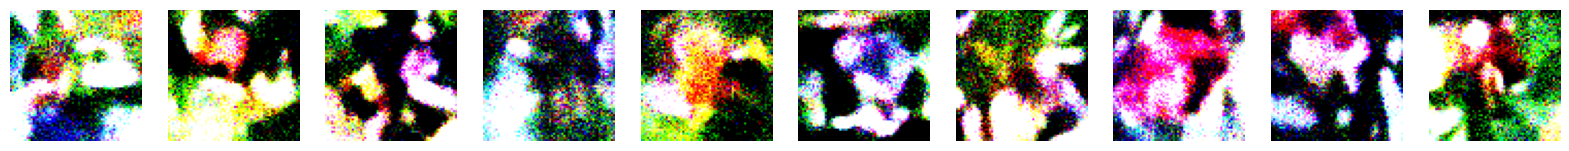

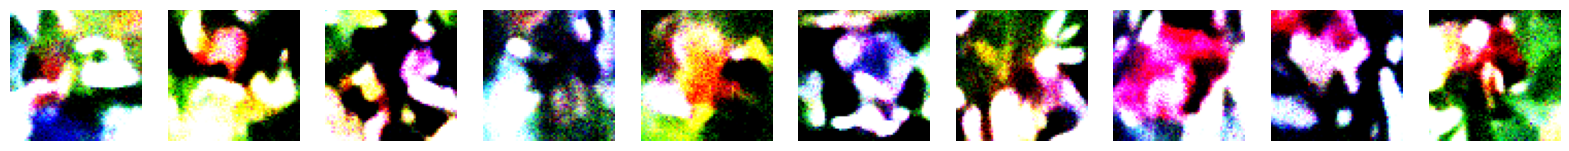

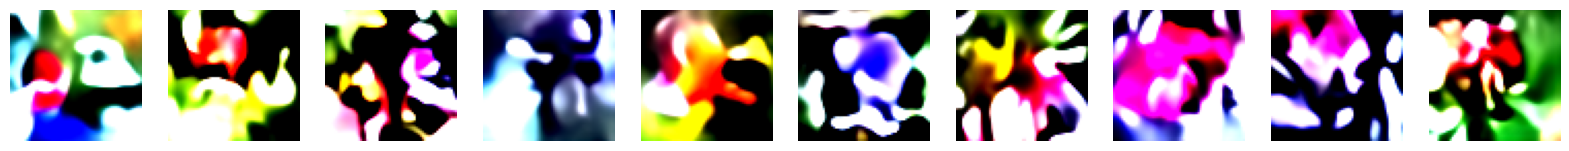

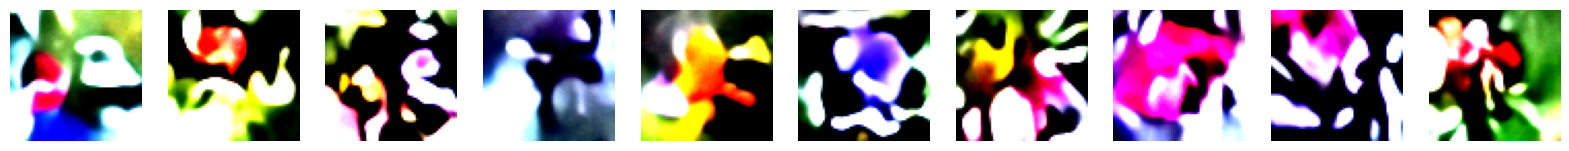

In [30]:
# View improvement over greater number of diffusion steps
for diffusion_steps in list(np.arange(1, 6, 1)) + [20] + [100]:
    torch.manual_seed(42)
    with torch.no_grad():
        generated_images = ddm.generate(
            num_images=10,
            diffusion_steps=diffusion_steps,
        ).permute(0,2,3,1).cpu().numpy()
    display_imgs(generated_images)

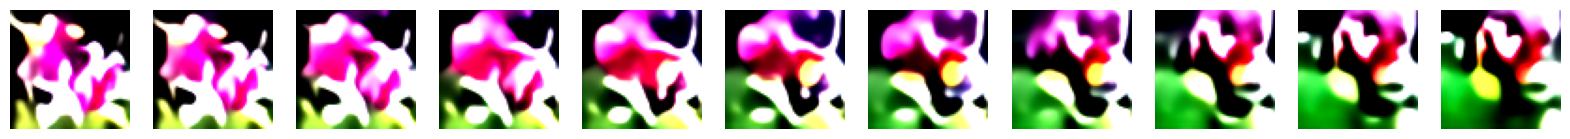

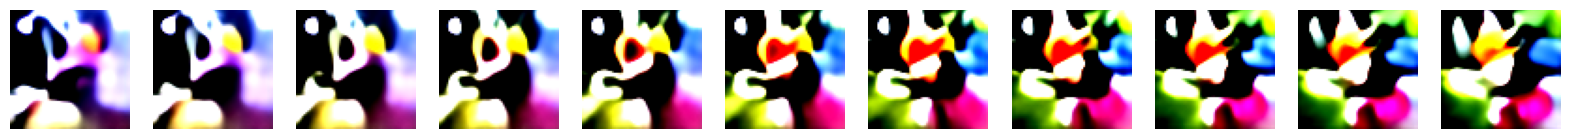

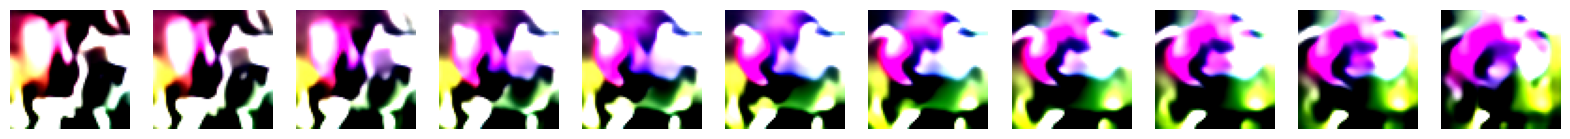

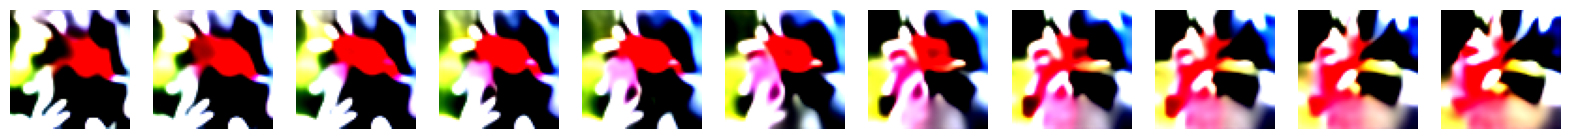

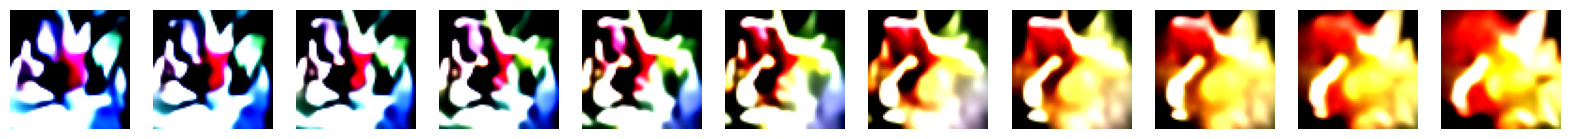

In [ ]:
import math

# Interpolation between two points in the latent space
torch.manual_seed(100)

device = 'cuda' if torch.cuda.is_available else 'cpu'

def spherical_interpolation(a, b, t):
    return torch.sin(t * math.pi / 2) * a + torch.cos(t * math.pi / 2) * b

with torch.no_grad():
    for i in range(5):
        a = torch.randn((IMAGE_SIZE, IMAGE_SIZE, 3))
        b = torch.randn((IMAGE_SIZE, IMAGE_SIZE, 3))
        initial_noise = torch.stack(
            [spherical_interpolation(a, b, t) for t in torch.arange(0, 1.1, 0.1)]
        ).to(device).permute(0,3,1,2)
        generated_images = ddm.generate(
            num_images=2, diffusion_steps=20, initial_noise=initial_noise
        ).permute(0,2,3,1).cpu().numpy()
        display_imgs(generated_images, n=11)